# Introducción a Redes Neuronales Convolucionales (CNN) con FashionMNIST

En esta notebook, implementaremos una Red Neuronal Convolucional (CNN) básica y aprenderemos conceptos fundamentales como convoluciones y pooling, utilizando el dataset [FashionMNIST](https://en.wikipedia.org/wiki/Fashion_MNIST). El objetivo principal es entender cómo las CNNs pueden ser aplicadas a problemas de clasificación de imágenes.

## Objetivos

1. **Entender los conceptos básicos de las Redes Neuronales Convolucionales (CNN)**, incluyendo convoluciones, capas de pooling y capas totalmente conectadas.
2. **Entrenar una CNN** en PyTorch utilizando el dataset FashionMNIST.
3. **Evaluar el rendimiento del modelo** utilizando métricas adecuadas y visualización de resultados.

In [58]:
!pip install torchinfo

In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import v2 as T
from torchvision.io import read_image, ImageReadMode

from torchinfo import summary

import os
from pathlib import Path

from utils import (
    train,
    model_calassification_report,
    show_tensor_image,
    show_tensor_images,
)

In [60]:
# Fijamos la semilla para que los resultados sean reproducibles
SEED = 34

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [61]:
import sys

# definimos el dispositivo que vamos a usar
DEVICE = "cpu"  # por defecto, usamos la CPU
if torch.cuda.is_available():
    DEVICE = "cuda"  # si hay GPU, usamos la GPU
elif torch.backends.mps.is_available():
    DEVICE = "mps"  # si no hay GPU, pero hay MPS, usamos MPS
elif torch.xpu.is_available():
    DEVICE = "xpu"  # si no hay GPU, pero hay XPU, usamos XPU

print(f"Usando {DEVICE}")

NUM_WORKERS = 0 # Win y MacOS pueden tener problemas con múltiples workers
if sys.platform == 'linux':
    NUM_WORKERS = 4  # numero de workers para cargar los datos (depende de cada caso)

print(f"Usando {NUM_WORKERS}")


Usando cuda
Usando 4


In [62]:

BATCH_SIZE = 128  # tamaño del batch

## Intro a CNNs

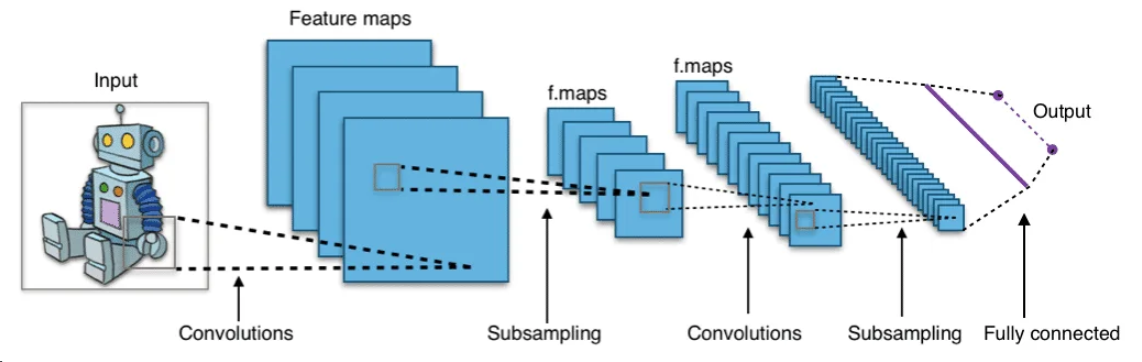

Las redes convolucionales (CNNs) son muy utilizadas en el campo de **computer vision**, es decir, en problemas relacionados con imágenes como clasificación, detección de objetos, segmentación, etc. Los dos conceptos clave en las CNNs son las **convoluciones** y el **pooling**. Debido a que los pixeles de una imagen tienen una relación espacial, las CNNs son capaces de capturar patrones locales en la imagen, como bordes, texturas, etc.


### Convoluciones

En el contexto de las CNNs, las convoluciones se aplican a una imagen de entrada y un filtro (kernel) para producir una imagen de salida. La operación de convolución se realiza deslizando el filtro sobre la imagen de entrada, multiplicando sus valores por los valores de los píxeles de la imagen y sumando el resultado.

![Image](https://d2l.ai/_images/correlation.svg)

Vamos a ver algunos ejemplos de convoluciones y como afectan a las imágenes. Para ellos vamos a utilizar la función [`torch.nn.functional.conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.functional.conv2d.html) de PyTorch.

In [63]:
input = torch.tensor([[0, 1, 2], [3, 4, 5], [6, 7, 8]], dtype=torch.float32)
kernel = torch.tensor([[0, 1], [2, 3]], dtype=torch.float32)

# para utilizar F.conv2d, necesitamos que las dimensiones de kernel sean [out_channels, in_channels, kernel_height, kernel_width]
# y las dimensiones de input sean [batch_size, in_channels, height, width]

input = input.reshape(1, 1, *input.shape)
kernel = kernel.reshape(1, 1, *kernel.shape)

F.conv2d(input, kernel)

tensor([[[[19., 25.],
          [37., 43.]]]])

Veamos un ejemplo de cómo se aplica una convolución a una imagen real. En este caso, vamos a definir filtros que ayudan a detectar bordes.

La función [read_image](https://pytorch.org/vision/stable/generated/torchvision.io.read_image.html) es una función auxiliar que lee una imagen de un archivo y la convierte en un tensor de PyTorch.

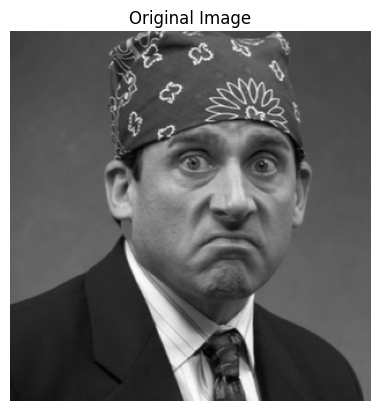

In [64]:
image = read_image(str(Path("assets") / "PrisonMike.png"), ImageReadMode.GRAY)

show_tensor_image(image, title="Original Image", vmin=0, vmax=255)

Definimos los siguientes filtros:

- `identity`: un filtro que no modifica la imagen.
- `edge`: detecta bordes.
- `sharpen`: resalta los bordes.
- `blur`: suaviza la imagen.

Forma de la imagen: torch.Size([1, 1, 320, 312])
Forma de los kernels: torch.Size([3, 1, 3, 3])
Forma de la salida: torch.Size([1, 3, 318, 310])


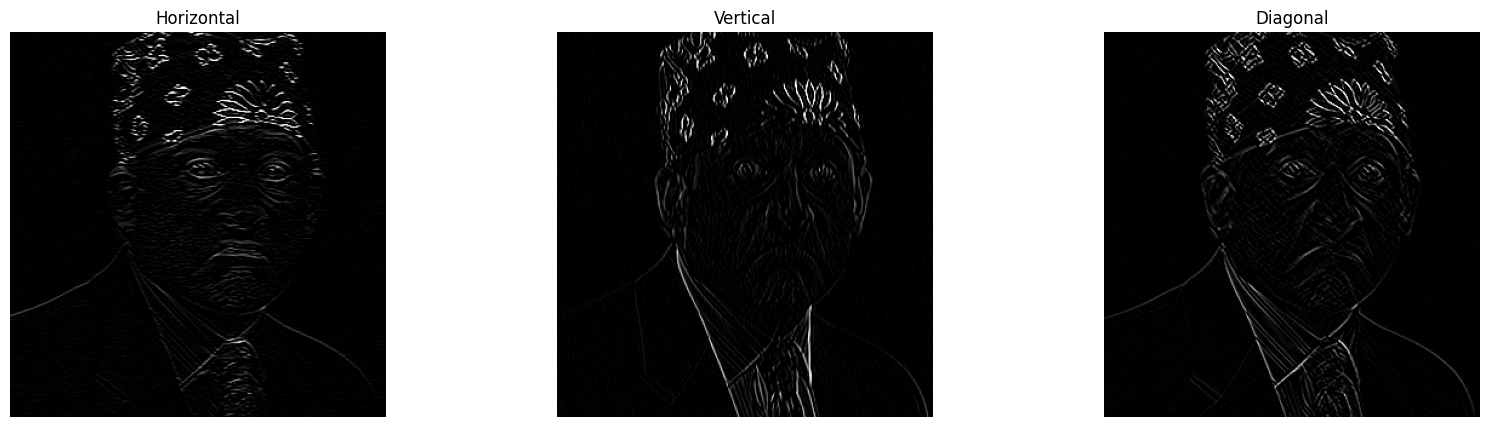

In [65]:
image_n = image.to(torch.float32)
image_batch = image_n.unsqueeze(0)

print("Forma de la imagen:", image_batch.shape)

horizontal_edge = torch.tensor([[[[-1, -1, -1],
                                  [ 2,  2,  2],
                                  [-1, -1, -1]]]], dtype=torch.float32) # kernels conocidos

vertical_edge = torch.tensor([[[[-1,  2, -1],
                                [-1,  2, -1],
                                [-1,  2, -1]]]], dtype=torch.float32)

diagonal_edge = torch.tensor([[[[2, -1, -1],
                                [-1, 2, -1],
                                [-1, -1, 2]]]], dtype=torch.float32)


# Apilar los kernels para aplicarlos todos a la vez
kernels = torch.cat([horizontal_edge, vertical_edge, diagonal_edge])
print("Forma de los kernels:", kernels.shape)

# Aplicar la convolución usando los kernels definidos
output = F.conv2d(image_batch, kernels)
print("Forma de la salida:", output.shape)

# Mostrar las imágenes resultantes
show_tensor_images(
    [output[0, i].unsqueeze(0) for i in range(output.shape[1])],
    titles=["Horizontal", "Vertical", "Diagonal"],
    figsize=(20, 5),
    vmin=0,
    vmax=255,
)

Forma de los kernels: torch.Size([5, 1, 3, 3])
Forma de la salida: torch.Size([1, 5, 318, 310])


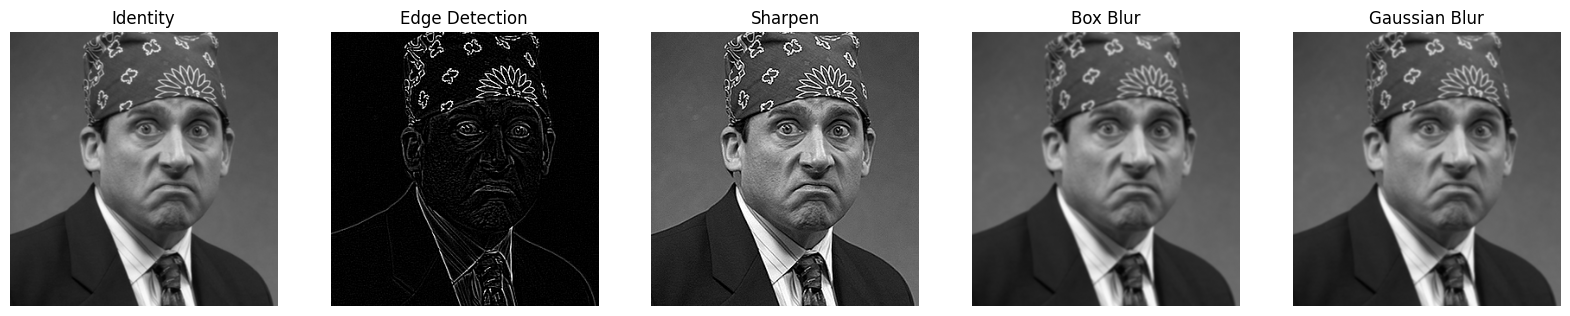

In [66]:
identity = torch.tensor([[[[0, 0, 0],
                           [0, 1, 0],
                           [0, 0, 0]]]], dtype=torch.float32)

edge = torch.tensor([[[[-1, -1, -1],
                       [-1, 8, -1],
                       [-1, -1, -1]]]], dtype=torch.float32)

sharpen = torch.tensor([[[[0, -1, 0],
                          [-1, 5, -1],
                          [0, -1, 0]]]], dtype=torch.float32)

box_blur = torch.tensor([[[[1, 1, 1],
                           [1, 1, 1],
                           [1, 1, 1]]]], dtype=torch.float32) / 9

gau_blur = torch.tensor([[[[1, 2, 1],
                           [2, 4, 2],
                           [1, 2, 1]]]], dtype=torch.float32) / 16


# Apilar los kernels para aplicarlos todos a la vez
kernels = torch.cat([identity, edge, sharpen, box_blur, gau_blur])
print("Forma de los kernels:", kernels.shape)

# Aplicar la convolución usando los kernels definidos
output = F.conv2d(image_batch, kernels)
print("Forma de la salida:", output.shape)

# Mostrar las imágenes resultantes
show_tensor_images(
    [output[0, i].unsqueeze(0) for i in range(output.shape[1])],
    titles=["Identity", "Edge Detection", "Sharpen", "Box Blur", "Gaussian Blur"],
    figsize=(20, 5),
    vmin=0,
    vmax=255,
)

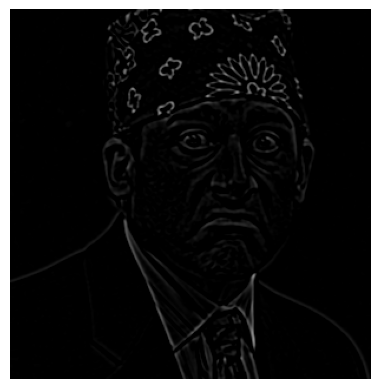

In [67]:
# podemos combinar
output = F.conv2d(image_batch, edge)
output = F.conv2d(output, box_blur)
output = F.conv2d(output, gau_blur)

show_tensor_image(output, vmin=0, vmax=255)

La buena noticia es que no necesitamos definir estos filtros manualmente, ya que PyTorch proporciona una función [`torch.nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) que inicializa los pesos de los filtros de manera aleatoria y los entrena durante el proceso de aprendizaje.

Esto quiere decir que la red neuronal aprenderá automáticamente los filtros que son útiles para el problema en cuestión.

#### Otros parámetros de la convolución

Además de los filtros, las convoluciones tienen otros parámetros importantes:

- `stride`: paso de la convolución, es decir, cuántos píxeles se desplaza el filtro en cada paso.
- `padding`: relleno de la imagen, es decir, cuántos píxeles se añaden alrededor de la imagen. Muchas veces se utiliza para mantener el tamaño de la imagen de salida igual al de la imagen de entrada.
- `bias`: si se incluye un término de sesgo en la convolución.


Las dimensiones de salida se pueden calcular con la siguiente fórmula:

$$
\text{output_size} = \frac{\text{input_size} - \text{kernel_size} + 2 \times \text{padding}}{\text{stride}} + 1
$$

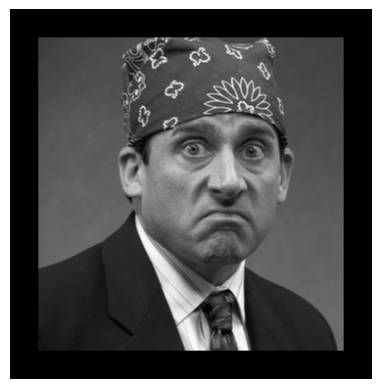

Shape de la imagen original: torch.Size([1, 1, 320, 312])
Shape de la imagen con padding: torch.Size([1, 1, 378, 370])


In [68]:
output = F.conv2d(image_batch, identity, padding=30)  # sumamos 30 pixeles de padding
show_tensor_image(output, vmin=0, vmax=255)

print(f"Shape de la imagen original: {image_batch.shape}")
print(f"Shape de la imagen con padding: {output.shape}")

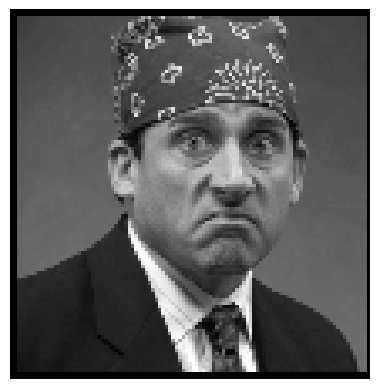

Shape de la imagen con stride: torch.Size([1, 1, 110, 107])


In [69]:
output = F.conv2d(image_batch, identity, stride=3, padding=5)
show_tensor_image(output)

print(f"Shape de la imagen con stride: {output.shape}")

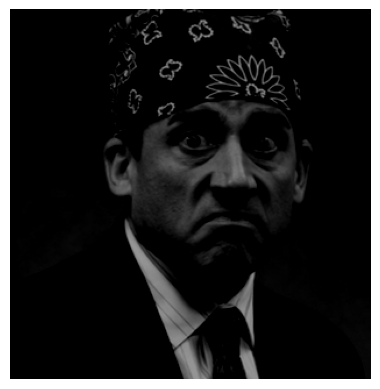

In [70]:
output = F.conv2d(image_batch, identity, bias=torch.tensor([-100.0]))
show_tensor_image(output, vmin=0, vmax=255)

### Pooling

El **Pooling** es una operación clave en las redes neuronales convolucionales (CNNs) que se utiliza para reducir las dimensiones espaciales (ancho y alto) de los mapas de características. Esto se logra resumiendo las características en regiones específicas de la imagen de entrada. El pooling ayuda a disminuir la cantidad de parámetros y el costo computacional, y también proporciona cierta invariancia a las traslaciones y deformaciones en la entrada.

> Cabe destacar que el pooling no tiene parámetros entrenables, ya que simplemente aplica una función fija a una región de la imagen.

#### Tipos de Pooling

Existen varios tipos de pooling, pero los más comunes son:

1. **Max Pooling**: Selecciona el valor máximo en cada ventana de pooling. Es útil para resaltar las características más prominentes.
2. **Average Pooling**: Calcula el promedio de los valores en cada ventana de pooling. Suaviza las características y es menos agresivo que el max pooling.

En PyTorch, podemos aplicar pooling utilizando la función [`torch.nn.functional.max_pool2d`](https://pytorch.org/docs/stable/generated/torch.nn.functional.max_pool2d.html) o [`torch.nn.functional.avg_pool2d`](https://pytorch.org/docs/stable/generated/torch.nn.functional.avg_pool2d.html).

#### Dimensiones de salida

Las dimensiones de salida del pooling se pueden calcular con la siguiente fórmula:

$$
\text{output_size} = \frac{\text{input_size} - \text{kernel_size} + 2 \times \text{padding}}{\text{stride}} + 1
$$

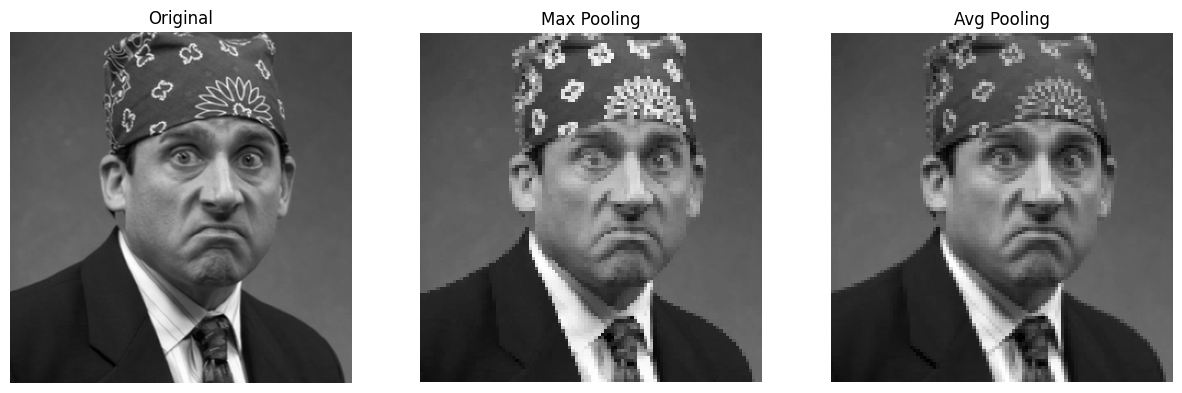

Shape de la imagen original: torch.Size([1, 1, 320, 312])
Shape de la imagen con Max Pooling: torch.Size([1, 1, 106, 104])
Shape de la imagen con Avg Pooling: torch.Size([1, 1, 106, 104])


In [71]:
# vemos un pooling en acción
max_pool_out = F.max_pool2d(image_batch, kernel_size=3)
avg_pool_out = F.avg_pool2d(image_batch, kernel_size=3)

show_tensor_images(
    [image_n, max_pool_out, avg_pool_out],
    titles=["Original", "Max Pooling", "Avg Pooling"],
)

print(f"Shape de la imagen original: {image_batch.shape}")
print(f"Shape de la imagen con Max Pooling: {max_pool_out.shape}")
print(f"Shape de la imagen con Avg Pooling: {avg_pool_out.shape}")

## Carga de datos

### Dataset FashionMNIST

El dataset FashionMNIST es una alternativa al clásico MNIST. En lugar de contener dígitos escritos a mano, FashionMNIST incluye imágenes de artículos de moda divididos en 10 clases, tales como camisetas, zapatos y bolsos. Cada imagen es de 28x28 píxeles en escala de grises, lo que hace que este dataset sea ideal para probar algoritmos de clasificación de imágenes.

Para facilitar el manejo del dataset FashionMNIST, utilizaremos la biblioteca `torchvision.datasets`, la cual proporciona una manera sencilla de cargar y preprocesar estos datos.

**Cargando el dataset con torchvision**

La clase `torchvision.datasets.FashionMNIST` permite descargar y cargar el dataset FashionMNIST de manera eficiente.

```python
datasets.FashionMNIST(
    root="data",
    train=True,
    transform=None,
    target_transform=None,
    download=True
)
```

Algunos de los parámetros más importantes son:

- `root`: Directorio donde se almacenarán los datos.
- `train`: Si es `True`, carga el conjunto de entrenamiento; si es `False`, carga el conjunto de prueba.
- `transform`: Transformaciones que se aplicarán a los datos.
- `target_transform`: Transformaciones que se aplicarán a las etiquetas.
- `download`: Si es `True`, descarga el dataset desde internet y lo almacena en `root`

Existen otros datasets disponibles en `torchvision.datasets`, como CIFAR10, CIFAR100, MNIST, etc. Puedes consultar la [documentación oficial](https://pytorch.org/vision/stable/datasets.html) para más información.


#### Transformaciones

Las transformaciones son operaciones que se aplican a los datos antes de ser alimentados a la red neuronal. En este caso, utilizamos `transforms.Compose` para combinar varias transformaciones. Dos transformaciones comunes son:

1. [transforms.ToImage](https://pytorch.org/vision/stable/generated/torchvision.transforms.v2.ToImage.html): Convierte los datos (PIL) a un tensor de imagen.
2. [transforms.ToDtype](https://pytorch.org/vision/stable/generated/torchvision.transforms.v2.ToDtype.html): Convierte los datos a un tipo de dato específico.

Al combinar estas transformaciones, nos aseguramos de que los datos estén en el formato y rango adecuado para ser procesados por la red neuronal.

Estas transformaciones se aplican automáticamente cuando cargamos el dataset utilizando la clase `datasets.FashionMNIST` y se especifican en el parámetro `transform`. Para ver más detalles sobre las transformaciones disponibles en PyTorch, puedes consultar la [documentación oficial](https://pytorch.org/vision/0.19/auto_examples/transforms/plot_transforms_getting_started.html#sphx-glr-auto-examples-transforms-plot-transforms-getting-started-py).

> Algunas transformaciones puede usarse como data augmentation, es decir, para aumentar la cantidad de datos de entrenamiento. Por ejemplo, rotar, recortar, cambiar el brillo, etc.

In [72]:
DATA_DIR = Path("data")

transforms = T.Compose( # todo esto se aplica antes de entrar a la red
    [
        T.ToImage(), # lo pasamos a tensor
        T.ToDtype(torch.float32, scale=True),
        T.Resize((32, 32))
    ]
)

fmnist_train_dataset = datasets.FashionMNIST(
    DATA_DIR, download=True, train=True, transform=transforms
)

fmnist_test_dataset = datasets.FashionMNIST(
    DATA_DIR, download=True, train=False, transform=transforms
)

In [73]:
fmnist_train_dataset[0][0].size()

torch.Size([1, 32, 32])

In [74]:
name_classes = fmnist_train_dataset.classes
nclasses = len(name_classes)

print(f"Clases: {name_classes}")

Clases: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Dividimos el dataset en conjuntos de entrenamiento para tener un conjunto de validación.

In [75]:
fmnist_train_dataset, fmnist_val_dataset = random_split(
    fmnist_train_dataset, [0.8, 0.2]
)

### DataLoaders

In [76]:
def get_dataloaders(batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):  # los num_workers juegan en las transformaciones
    train_loader = DataLoader(
        fmnist_train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
    )

    val_loader = DataLoader(
        fmnist_val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )


    test_loader = DataLoader(
        fmnist_test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    return train_loader, val_loader, test_loader


train_loader, val_loader, test_loader = get_dataloaders()

## Modelo de CNN

Igual que con el modelo FeedForward, para crear un modelo usando convoluciones necesitamos crear una clase, definir los metodos **init** y **forward** y especificar la arcquitectura y comportamiento de los componentes del modelo.

En particular vamos a usar:

- [Capas convolucionales de 2D](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d) a las que tenemos que especificarles la cantidad de canales de entrada (1 para gris, 3 para color y X para el resultado de un filtro anterior), una cantidad de filtros a usar (out_channels), el tamaño de los mismos (kernel_size) y si aplicamos padding (relleno) o no (esto nos permite hacer convoluciones que no modifiquen el tamaño original de las imagenes).

- [Capas de maxpooling](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d) o [avgpooling](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html#torch.nn.AvgPool2d) a las que tenemos que decirles el tamaño de la ventana a mirar y el largo del paso que deben tomar (stride).

- Finalmente tambien haremos uso de capas lineales y ReLUs como hicimos anteriormente.

### LeNet

Vamos a implementar [LeNet](https://d2l.ai/chapter_convolutional-neural-networks/lenet.html) que es una de las primeras redes neuronales convolucionales que se utilizó en la práctica. Fue propuesta por Yann LeCun en 1998 para el reconocimiento de dígitos escritos a mano. La arquitectura de LeNet es la siguiente:


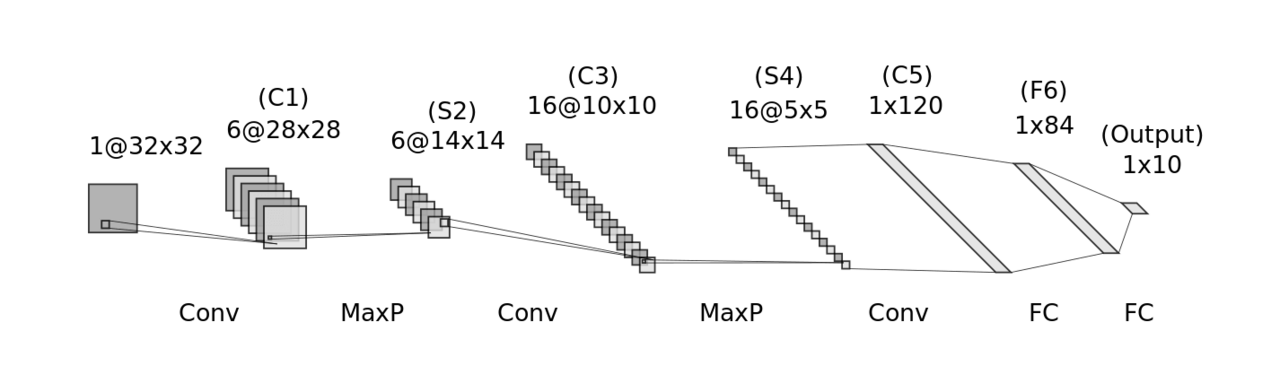


> Nota: En la arquitectura original de LeNet la entrada es de 32x32 pixeles, pero en este caso vamos a usar imagenes de 28x28 pixeles.

FC = Fully Connected

https://www.geeksforgeeks.org/lenet-5-architecture/


In [77]:
class LeNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(LeNet, self).__init__()
        # TODO
        self.conv1 = nn.Conv2d(in_channels, out_channels=6, kernel_size=5)  # parametros del paper, estan en el link de geeks for geeks
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5)
        self.tanh = nn.Tanh()
        self.linear = nn.Linear(in_features=120, out_features=84)
        self.output = nn.Linear(in_features=84, out_features=num_classes)
        self.flatten = nn.Flatten(start_dim=1)

    def forward(self, x):
        # TODO
        x = self.tanh(self.conv1(x))
        x = self.pool(x)
        x = self.tanh(self.conv2(x))
        x = self.pool(x)
        x = self.tanh(self.conv3(x))
        # [128, 120, 1, 1]
        x = self.flatten(x)
        # [128, 120]
        x = self.tanh(self.linear(x))

        return self.output(x)

summary(LeNet(1, 10), input_size=(BATCH_SIZE, 1, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [128, 10]                 --
├─Conv2d: 1-1                            [128, 6, 28, 28]          156
├─Tanh: 1-2                              [128, 6, 28, 28]          --
├─AvgPool2d: 1-3                         [128, 6, 14, 14]          --
├─Conv2d: 1-4                            [128, 16, 10, 10]         2,416
├─Tanh: 1-5                              [128, 16, 10, 10]         --
├─AvgPool2d: 1-6                         [128, 16, 5, 5]           --
├─Conv2d: 1-7                            [128, 120, 1, 1]          48,120
├─Tanh: 1-8                              [128, 120, 1, 1]          --
├─Flatten: 1-9                           [128, 120]                --
├─Linear: 1-10                           [128, 84]                 10,164
├─Tanh: 1-11                             [128, 84]                 --
├─Linear: 1-12                           [128, 10]                 850
To

### Entrenamiento

In [78]:
# TODO
LR = 0.001
EPOCHS = 10

letnet_model = LeNet(1, 10).to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimzer = optim.Adam(letnet_model.parameters(), lr=LR)

_, _ = train(letnet_model,
             optimzer,
             criterion,
             train_loader,
             val_loader,
             DEVICE,
             True,
             5,
             EPOCHS)

Epoch: 001 | Train Loss: 0.72669 | Val Loss: 0.53095
Epoch: 002 | Train Loss: 0.47050 | Val Loss: 0.43044
Epoch: 003 | Train Loss: 0.41361 | Val Loss: 0.41244
Epoch: 004 | Train Loss: 0.38156 | Val Loss: 0.38830
Epoch: 005 | Train Loss: 0.35593 | Val Loss: 0.35355
Epoch: 006 | Train Loss: 0.33646 | Val Loss: 0.34658
Epoch: 007 | Train Loss: 0.32046 | Val Loss: 0.33714
Epoch: 008 | Train Loss: 0.30942 | Val Loss: 0.33407
Epoch: 009 | Train Loss: 0.29605 | Val Loss: 0.33254
Epoch: 010 | Train Loss: 0.28751 | Val Loss: 0.32458


## Resultados

In [79]:
model_calassification_report(letnet_model, val_loader, DEVICE, nclasses)

Accuracy: 0.8759

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.74      0.91      0.82      1156
           1       0.99      0.96      0.98      1174
           2       0.79      0.82      0.80      1255
           3       0.89      0.87      0.88      1200
           4       0.78      0.82      0.80      1207
           5       0.96      0.96      0.96      1177
           6       0.77      0.54      0.64      1227
           7       0.95      0.94      0.94      1188
           8       0.95      0.98      0.96      1216
           9       0.96      0.96      0.96      1200

    accuracy                           0.88     12000
   macro avg       0.88      0.88      0.87     12000
weighted avg       0.88      0.88      0.87     12000



## Ejercicios

1. **Implementar una CNN más profunda**: Modificar la arquitectura de la red para agregar más capas convolucionales y/o capas totalmente conectadas. ¿Cómo afecta esto al rendimiento del modelo?
2. **Weigth and Bias**: Utilizar la librería [Weights and Biases](https://wandb.ai/site) para correr experimentos y comparar diferentes hiperparametros.


### Mas convoluciones

Original: conv1 → conv2 → pool → conv3 → flatten → fc.

Variante: conv1 → pool → conv2 → pool → conv3a → conv3b → flatten → fc.

In [80]:
class LeNetMasConv(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(LeNetMasConv, self).__init__()
        self.tanh = nn.Tanh()
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

        # Convoluciones
        self.conv1 = nn.Conv2d(in_channels, 6, kernel_size=5)   # (32→28)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)            # (14→10)
        self.conv3a = nn.Conv2d(16, 32, kernel_size=3)          # (5→3)
        self.conv3b = nn.Conv2d(32, 120, kernel_size=3)         # (3→1)

        # Flatten y fully connected
        self.flatten = nn.Flatten(start_dim=1)                  # (N, 120)
        self.fc1 = nn.Linear(120, 84)
        self.output = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.tanh(self.conv1(x))   # (N, 6, 28, 28)
        x = self.pool(x)               # (N, 6, 14, 14)

        x = self.tanh(self.conv2(x))   # (N,16, 10,10)
        x = self.pool(x)               # (N,16, 5,5)

        x = self.tanh(self.conv3a(x))  # (N,32, 3,3)
        x = self.tanh(self.conv3b(x))  # (N,120,1,1)

        x = self.flatten(x)            # (N,120)
        x = self.tanh(self.fc1(x))     # (N,84)
        return self.output(x)

summary(LeNetMasConv(1, 10), input_size=(BATCH_SIZE, 1, 32, 32))


Layer (type:depth-idx)                   Output Shape              Param #
LeNetMasConv                             [128, 10]                 --
├─Conv2d: 1-1                            [128, 6, 28, 28]          156
├─Tanh: 1-2                              [128, 6, 28, 28]          --
├─AvgPool2d: 1-3                         [128, 6, 14, 14]          --
├─Conv2d: 1-4                            [128, 16, 10, 10]         2,416
├─Tanh: 1-5                              [128, 16, 10, 10]         --
├─AvgPool2d: 1-6                         [128, 16, 5, 5]           --
├─Conv2d: 1-7                            [128, 32, 3, 3]           4,640
├─Tanh: 1-8                              [128, 32, 3, 3]           --
├─Conv2d: 1-9                            [128, 120, 1, 1]          34,680
├─Tanh: 1-10                             [128, 120, 1, 1]          --
├─Flatten: 1-11                          [128, 120]                --
├─Linear: 1-12                           [128, 84]                 10,164


In [81]:
LR = 0.001
EPOCHS = 10

letnet_masconv_model = LeNetMasConv(1, 10).to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimzer = optim.Adam(letnet_masconv_model.parameters(), lr=LR)

_, _ = train(letnet_masconv_model,
             optimzer,
             criterion,
             train_loader,
             val_loader,
             DEVICE,
             True,
             5,
             EPOCHS)

Epoch: 001 | Train Loss: 0.82343 | Val Loss: 0.57642
Epoch: 002 | Train Loss: 0.53238 | Val Loss: 0.48228
Epoch: 003 | Train Loss: 0.45824 | Val Loss: 0.43732
Epoch: 004 | Train Loss: 0.41525 | Val Loss: 0.41159
Epoch: 005 | Train Loss: 0.38059 | Val Loss: 0.38337
Epoch: 006 | Train Loss: 0.35637 | Val Loss: 0.35329
Epoch: 007 | Train Loss: 0.33530 | Val Loss: 0.35887
Epoch: 008 | Train Loss: 0.32332 | Val Loss: 0.33577
Epoch: 009 | Train Loss: 0.30746 | Val Loss: 0.33411
Epoch: 010 | Train Loss: 0.29758 | Val Loss: 0.32001


### Mas FC

Mismas capas de conv que la original, mas FC

In [82]:
class LeNetMasFC(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(LeNetMasFC, self).__init__()
        # TODO
        self.conv1 = nn.Conv2d(in_channels, out_channels=6, kernel_size=5)  # parametros del paper, estan en el link de geeks for geeks
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5)
        self.tanh = nn.Tanh()
        #self.linear = nn.Linear(in_features=120, out_features=84)
        self.linear1 = nn.Linear(in_features=120, out_features=250)
        self.linear2 = nn.Linear(in_features=250, out_features=100)
        self.linear3 = nn.Linear(in_features=100, out_features=84)  # mantengo 84 para el output como la original
        self.output = nn.Linear(in_features=84, out_features=num_classes)
        self.flatten = nn.Flatten(start_dim=1)

    def forward(self, x):
        # TODO
        x = self.tanh(self.conv1(x))
        x = self.pool(x)
        x = self.tanh(self.conv2(x))
        x = self.pool(x)
        x = self.tanh(self.conv3(x))
        # [128, 120, 1, 1]
        x = self.flatten(x)
        # [128, 120]
        x = self.tanh(self.linear1(x))    # (N, 250)
        x = self.tanh(self.linear2(x))    # (N, 100)
        x = self.tanh(self.linear3(x))    # (N, 84)

        return self.output(x)

summary(LeNetMasFC(1, 10), input_size=(BATCH_SIZE, 1, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
LeNetMasFC                               [128, 10]                 --
├─Conv2d: 1-1                            [128, 6, 28, 28]          156
├─Tanh: 1-2                              [128, 6, 28, 28]          --
├─AvgPool2d: 1-3                         [128, 6, 14, 14]          --
├─Conv2d: 1-4                            [128, 16, 10, 10]         2,416
├─Tanh: 1-5                              [128, 16, 10, 10]         --
├─AvgPool2d: 1-6                         [128, 16, 5, 5]           --
├─Conv2d: 1-7                            [128, 120, 1, 1]          48,120
├─Tanh: 1-8                              [128, 120, 1, 1]          --
├─Flatten: 1-9                           [128, 120]                --
├─Linear: 1-10                           [128, 250]                30,250
├─Tanh: 1-11                             [128, 250]                --
├─Linear: 1-12                           [128, 100]                25,100

In [83]:
LR = 0.001
EPOCHS = 10

letnet_masfc_model = LeNetMasFC(1, 10).to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimzer = optim.Adam(letnet_masfc_model.parameters(), lr=LR)

_, _ = train(letnet_masfc_model,
             optimzer,
             criterion,
             train_loader,
             val_loader,
             DEVICE,
             True,
             5,
             EPOCHS)

Epoch: 001 | Train Loss: 0.79175 | Val Loss: 0.56349
Epoch: 002 | Train Loss: 0.51912 | Val Loss: 0.46734
Epoch: 003 | Train Loss: 0.45461 | Val Loss: 0.43487
Epoch: 004 | Train Loss: 0.41662 | Val Loss: 0.39588
Epoch: 005 | Train Loss: 0.38760 | Val Loss: 0.38713
Epoch: 006 | Train Loss: 0.36656 | Val Loss: 0.36118
Epoch: 007 | Train Loss: 0.34968 | Val Loss: 0.35724
Epoch: 008 | Train Loss: 0.33290 | Val Loss: 0.38292
Epoch: 009 | Train Loss: 0.32087 | Val Loss: 0.33418
Epoch: 010 | Train Loss: 0.30856 | Val Loss: 0.34063


### Combinacion de las dos pruebas anteriores

In [84]:
class LeNetDeeper(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(LeNetDeeper, self).__init__()
        self.tanh = nn.Tanh()
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

        # Convoluciones
        self.conv1 = nn.Conv2d(in_channels, 6, kernel_size=5)   # (32→28)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)            # (14→10)
        self.conv3a = nn.Conv2d(16, 32, kernel_size=3)          # (5→3)
        self.conv3b = nn.Conv2d(32, 120, kernel_size=3)         # (3→1)

        # Flatten y fully connected
        self.flatten = nn.Flatten(start_dim=1)                  # (N, 120)
        self.linear1 = nn.Linear(in_features=120, out_features=250)
        self.linear2 = nn.Linear(in_features=250, out_features=100)
        self.linear3 = nn.Linear(in_features=100, out_features=84)  # mantengo 84 para el output como la original

        self.output = nn.Linear(in_features=84, out_features=num_classes)

    def forward(self, x):
        x = self.tanh(self.conv1(x))   # (N, 6, 28, 28)
        x = self.pool(x)               # (N, 6, 14, 14)

        x = self.tanh(self.conv2(x))   # (N,16, 10,10)
        x = self.pool(x)               # (N,16, 5,5)

        x = self.tanh(self.conv3a(x))  # (N,32, 3,3)
        x = self.tanh(self.conv3b(x))  # (N,120,1,1)

        x = self.flatten(x)            # (N,120)
        x = self.tanh(self.linear1(x))     # (N,84)
        x = self.tanh(self.linear2(x))
        x = self.tanh(self.linear3(x))

        return self.output(x)

summary(LeNetDeeper(1, 10), input_size=(BATCH_SIZE, 1, 32, 32))


Layer (type:depth-idx)                   Output Shape              Param #
LeNetDeeper                              [128, 10]                 --
├─Conv2d: 1-1                            [128, 6, 28, 28]          156
├─Tanh: 1-2                              [128, 6, 28, 28]          --
├─AvgPool2d: 1-3                         [128, 6, 14, 14]          --
├─Conv2d: 1-4                            [128, 16, 10, 10]         2,416
├─Tanh: 1-5                              [128, 16, 10, 10]         --
├─AvgPool2d: 1-6                         [128, 16, 5, 5]           --
├─Conv2d: 1-7                            [128, 32, 3, 3]           4,640
├─Tanh: 1-8                              [128, 32, 3, 3]           --
├─Conv2d: 1-9                            [128, 120, 1, 1]          34,680
├─Tanh: 1-10                             [128, 120, 1, 1]          --
├─Flatten: 1-11                          [128, 120]                --
├─Linear: 1-12                           [128, 250]                30,250


In [85]:
LR = 0.001
EPOCHS = 10

lenet_deeper = LeNetDeeper(1, 10).to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimzer = optim.Adam(lenet_deeper.parameters(), lr=LR)

_, _ = train(lenet_deeper,
             optimzer,
             criterion,
             train_loader,
             val_loader,
             DEVICE,
             True,
             5,
             EPOCHS)

Epoch: 001 | Train Loss: 0.88470 | Val Loss: 0.63420
Epoch: 002 | Train Loss: 0.55273 | Val Loss: 0.52372
Epoch: 003 | Train Loss: 0.48764 | Val Loss: 0.46780
Epoch: 004 | Train Loss: 0.44473 | Val Loss: 0.42479
Epoch: 005 | Train Loss: 0.41334 | Val Loss: 0.39578
Epoch: 006 | Train Loss: 0.38499 | Val Loss: 0.39613
Epoch: 007 | Train Loss: 0.36561 | Val Loss: 0.37008
Epoch: 008 | Train Loss: 0.34889 | Val Loss: 0.35513
Epoch: 009 | Train Loss: 0.33569 | Val Loss: 0.33896
Epoch: 010 | Train Loss: 0.32233 | Val Loss: 0.36196


### Comparacion metricas 3 pruebas

In [86]:
print(f"======= LENET ORIGINAL =======\n")
model_calassification_report(letnet_model, val_loader, DEVICE, nclasses)
print(f"======= LENET CON MAS CONVOLUCIONES =======\n")
model_calassification_report(letnet_masconv_model, val_loader, DEVICE, nclasses)
print(f"======= LENET CON MAS FC LAYERS =======\n")
model_calassification_report(letnet_masfc_model, val_loader, DEVICE, nclasses)
print(f"======= LENET CON MAS CONV Y MAS FC LAYERS =======\n")
model_calassification_report(lenet_deeper, val_loader, DEVICE, nclasses)

======= LENET ORIGINAL =======

Accuracy: 0.8759

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.74      0.91      0.82      1156
           1       0.99      0.96      0.98      1174
           2       0.79      0.82      0.80      1255
           3       0.89      0.87      0.88      1200
           4       0.78      0.82      0.80      1207
           5       0.96      0.96      0.96      1177
           6       0.77      0.54      0.64      1227
           7       0.95      0.94      0.94      1188
           8       0.95      0.98      0.96      1216
           9       0.96      0.96      0.96      1200

    accuracy                           0.88     12000
   macro avg       0.88      0.88      0.87     12000
weighted avg       0.88      0.88      0.87     12000

======= LENET CON MAS CONVOLUCIONES =======

Accuracy: 0.8831

Reporte de clasificación:
               precision    recall  f1-score   support

           0       

### Weight and bias

In [88]:
import wandb

wandb.login()

True

In [89]:
WANDB_TEAM_NAME = "mc-ort"
WANDB_PROJECT = "LeNet"
os.environ["WANDB_NOTEBOOK_NAME"] = "./Clase05_CNNs_Intro_letra.ipynb"

In [91]:
sweep_config = {
    "name": "lenet-clasification-v2",
    "method": "random",
    "metric": {"name": "val_macro_f1", "goal": "maximize"},  # o "val_accuracy"
    "parameters": {
        "model_type": {"values": ["original", "mas_conv", "mas_fc"]},

        # Optimizador y LR
        "optimizer": {"values": ["adam", "sgd"]},
        "learning_rate": {"distribution": "log_uniform_values", "min": 1e-4, "max": 5e-3},
        "weight_decay": {"values": [0.0, 1e-4, 5e-4]},

        # Regularización en FC
        "dropout_p": {"values": [0.0, 0.2, 0.3]},

        # Data
        "batch_size": {"values": [64, 128, 256]},

        # Entrenamiento
        "epochs": {"value": 12},
        "scheduler": {"values": ["none", "step"]},
        "step_size": {"values": [6]},                     # usado si scheduler=step
        "gamma": {"values": [0.5]},                       # idem
        "label_smoothing": {"values": [0.0, 0.05]},
        "device": {"value": "cuda"},
        "seed": {"values": [7, 13]},
    },
}

sweep_id = wandb.sweep(sweep_config, project=WANDB_PROJECT)


Create sweep with ID: 4prt3n6x
Sweep URL: https://wandb.ai/mc-ort/LeNet/sweeps/4prt3n6x


In [92]:
def wand_log(epoch, train_loss, val_loss):
    wandb.log({"epoch": epoch + 1, "train_loss": train_loss, "val_loss": val_loss})


def sweep_run():
    """
    Función que se ejecutará en cada run del sweep.
    """
    # inicializar un nuevo run
    wandb.init()
    # leer la configuración del run
    config = wandb.config
    run_learning_rate = config.learning_rate
    run_optimizer = config.optimizer
    run_weight_decay = config.weight_decay
    run_batch_size = config.batch_size
    run_model = config.model_type

    # TODO
    # dataloaders
    train_loader, val_loader, _ = get_dataloaders(run_batch_size, NUM_WORKERS)

    # device
    if torch.cuda.is_available():
        # siempre la 1ª GPU en Colab es 0
        device = torch.device("cuda:0")
        # opcional: forzar visibilidad a solo esa
        os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    else:
        device = torch.device("cpu")
    wandb.config.update({"device": str(device)}, allow_val_change=True)

    # modelo
    if run_model == "original":
      model = LeNet(1, 10).to(DEVICE)
    elif run_model == "mas_conv":
      model = LeNetMasConv(1, 10).to(DEVICE)
    elif run_model == "mas_fc":
      model = LeNetMasFC(1, 10).to(DEVICE)
    elif run_model == "deeper":
      model = LeNetDeeper(1, 10).to(DEVICE)

    # optimizer
    if run_optimizer == "adam":
      optimizer = optim.Adam(model.parameters(), lr=run_learning_rate, weight_decay=run_weight_decay)
    elif run_optimizer == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=run_learning_rate, momentum=0.9, nesterov=True, weight_decay=run_weight_decay)

    train(model, optimizer, criterion, train_loader, val_loader, device=device, epochs=EPOCHS, log_fn=wand_log, log_every=1)
    
    # guardo pesos temporalmente
    fname = f"model_{wandb.run.id}.pth"
    torch.save(model.state_dict(), fname)
    wandb.save(fname)

    wandb.finish()

In [93]:
import torch
print(torch.cuda.is_available(), torch.cuda.device_count())


True 1


In [94]:
wandb.agent(sweep_id, function=sweep_run, count=10) # corre sweep_run 10 veces

wandb: Agent Starting Run: ktu20gbb with config:
wandb: 	batch_size: 256
wandb: 	device: cuda
wandb: 	dropout_p: 0.3
wandb: 	epochs: 12
wandb: 	gamma: 0.5
wandb: 	label_smoothing: 0
wandb: 	learning_rate: 0.0002483324985443253
wandb: 	model_type: mas_conv
wandb: 	optimizer: sgd
wandb: 	scheduler: none
wandb: 	seed: 7
wandb: 	step_size: 6
wandb: 	weight_decay: 0


wandb: WARNING Config item 'device' was locked by 'sweep' (ignored update).


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,███▇▇▆▆▅▃▁
val_loss,███▇▇▇▆▅▃▁
epoch,10
train_loss,2.16145
val_loss,2.12877


wandb: Agent Starting Run: tkidk0gp with config:
wandb: 	batch_size: 64
wandb: 	device: cuda
wandb: 	dropout_p: 0
wandb: 	epochs: 12
wandb: 	gamma: 0.5
wandb: 	label_smoothing: 0
wandb: 	learning_rate: 0.00010699383891454488
wandb: 	model_type: mas_fc
wandb: 	optimizer: adam
wandb: 	scheduler: none
wandb: 	seed: 13
wandb: 	step_size: 6
wandb: 	weight_decay: 0


wandb: WARNING Config item 'device' was locked by 'sweep' (ignored update).


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▂▁▁▁▁
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
train_loss,0.44413
val_loss,0.44025


wandb: Agent Starting Run: n9tr0p17 with config:
wandb: 	batch_size: 64
wandb: 	device: cuda
wandb: 	dropout_p: 0.2
wandb: 	epochs: 12
wandb: 	gamma: 0.5
wandb: 	label_smoothing: 0.05
wandb: 	learning_rate: 0.0003331598908888362
wandb: 	model_type: mas_fc
wandb: 	optimizer: sgd
wandb: 	scheduler: step
wandb: 	seed: 13
wandb: 	step_size: 6
wandb: 	weight_decay: 0.0001


wandb: WARNING Config item 'device' was locked by 'sweep' (ignored update).


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,██▆▄▃▂▂▂▁▁
val_loss,█▇▅▃▃▂▂▂▁▁
epoch,10
train_loss,0.84665
val_loss,0.81757


wandb: Agent Starting Run: w94a6b0u with config:
wandb: 	batch_size: 256
wandb: 	device: cuda
wandb: 	dropout_p: 0.3
wandb: 	epochs: 12
wandb: 	gamma: 0.5
wandb: 	label_smoothing: 0.05
wandb: 	learning_rate: 0.00029925169877931246
wandb: 	model_type: original
wandb: 	optimizer: adam
wandb: 	scheduler: none
wandb: 	seed: 7
wandb: 	step_size: 6
wandb: 	weight_decay: 0


wandb: WARNING Config item 'device' was locked by 'sweep' (ignored update).


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▂▁▁▁▁
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
train_loss,0.41502
val_loss,0.41558


wandb: Agent Starting Run: 6hnyrlso with config:
wandb: 	batch_size: 64
wandb: 	device: cuda
wandb: 	dropout_p: 0.3
wandb: 	epochs: 12
wandb: 	gamma: 0.5
wandb: 	label_smoothing: 0
wandb: 	learning_rate: 0.0008778300698420771
wandb: 	model_type: mas_fc
wandb: 	optimizer: adam
wandb: 	scheduler: step
wandb: 	seed: 13
wandb: 	step_size: 6
wandb: 	weight_decay: 0.0001


wandb: WARNING Config item 'device' was locked by 'sweep' (ignored update).


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▃▂▂▂▁▁▁
val_loss,█▅▄▄▂▂▂▁▁▁
epoch,10
train_loss,0.29474
val_loss,0.32354


wandb: Agent Starting Run: rgtsrsky with config:
wandb: 	batch_size: 256
wandb: 	device: cuda
wandb: 	dropout_p: 0.2
wandb: 	epochs: 12
wandb: 	gamma: 0.5
wandb: 	label_smoothing: 0.05
wandb: 	learning_rate: 0.00035354098965441355
wandb: 	model_type: mas_conv
wandb: 	optimizer: sgd
wandb: 	scheduler: none
wandb: 	seed: 13
wandb: 	step_size: 6
wandb: 	weight_decay: 0


wandb: WARNING Config item 'device' was locked by 'sweep' (ignored update).


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█████▇▇▆▃▁
val_loss,█████▇▇▅▃▁
epoch,10
train_loss,1.74997
val_loss,1.67392


wandb: Agent Starting Run: u6my62fa with config:
wandb: 	batch_size: 128
wandb: 	device: cuda
wandb: 	dropout_p: 0
wandb: 	epochs: 12
wandb: 	gamma: 0.5
wandb: 	label_smoothing: 0.05
wandb: 	learning_rate: 0.0011633366491424551
wandb: 	model_type: mas_conv
wandb: 	optimizer: sgd
wandb: 	scheduler: none
wandb: 	seed: 13
wandb: 	step_size: 6
wandb: 	weight_decay: 0


wandb: WARNING Config item 'device' was locked by 'sweep' (ignored update).


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▆▃▂▂▂▁▁▁▁
val_loss,█▄▃▂▂▂▁▁▁▁
epoch,10
train_loss,0.67207
val_loss,0.65444


wandb: Agent Starting Run: 99ys8s5m with config:
wandb: 	batch_size: 64
wandb: 	device: cuda
wandb: 	dropout_p: 0.3
wandb: 	epochs: 12
wandb: 	gamma: 0.5
wandb: 	label_smoothing: 0
wandb: 	learning_rate: 0.0004570826984941851
wandb: 	model_type: mas_conv
wandb: 	optimizer: adam
wandb: 	scheduler: step
wandb: 	seed: 13
wandb: 	step_size: 6
wandb: 	weight_decay: 0


wandb: WARNING Config item 'device' was locked by 'sweep' (ignored update).


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▃▂▂▂▁▁▁
val_loss,█▆▄▃▃▂▂▁▁▁
epoch,10
train_loss,0.31693
val_loss,0.33445


wandb: Agent Starting Run: kot5oa4r with config:
wandb: 	batch_size: 256
wandb: 	device: cuda
wandb: 	dropout_p: 0.3
wandb: 	epochs: 12
wandb: 	gamma: 0.5
wandb: 	label_smoothing: 0.05
wandb: 	learning_rate: 0.003553423884608719
wandb: 	model_type: mas_fc
wandb: 	optimizer: adam
wandb: 	scheduler: step
wandb: 	seed: 13
wandb: 	step_size: 6
wandb: 	weight_decay: 0.0005


wandb: WARNING Config item 'device' was locked by 'sweep' (ignored update).


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▂▂▂▁▁▁▁
val_loss,█▆▄▃▂▂▂▂▁▁
epoch,10
train_loss,0.33833
val_loss,0.34592


wandb: Agent Starting Run: w3poc0xo with config:
wandb: 	batch_size: 256
wandb: 	device: cuda
wandb: 	dropout_p: 0.2
wandb: 	epochs: 12
wandb: 	gamma: 0.5
wandb: 	label_smoothing: 0
wandb: 	learning_rate: 0.0009857576455937717
wandb: 	model_type: original
wandb: 	optimizer: sgd
wandb: 	scheduler: none
wandb: 	seed: 7
wandb: 	step_size: 6
wandb: 	weight_decay: 0.0001


wandb: WARNING Config item 'device' was locked by 'sweep' (ignored update).


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,██▆▄▃▂▂▂▁▁
val_loss,█▇▅▃▃▂▂▁▁▁
epoch,10
train_loss,0.77871
val_loss,0.75635


In [96]:
api = wandb.Api()

# nos traemos el sweep (objeto) para analizar los resultados
sweep = api.sweep(f"{WANDB_TEAM_NAME}/{WANDB_PROJECT}/{sweep_id}")

# obtenemos el mejor run
best_run = sweep.best_run()

# imprimimos el mejor run
print(f"Best run {best_run.name} with {best_run.summary['val_loss']}")

# descargamos el modelo del mejor run
best_run.file(f"model_{best_run.id}.pth").download(replace=True)

wandb: Sorting runs by -summary_metrics.val_macro_f1


Best run smart-sweep-5 with 0.3235405223800781


<_io.TextIOWrapper name='./model_6hnyrlso.pth' mode='r' encoding='UTF-8'>

In [102]:
_, _, test_loader = get_dataloaders(BATCH_SIZE, NUM_WORKERS)

model_type = best_run.config.get("model_type", "original")

model_path = f"model_{best_run.id}.pth"   # asegúrate que está descargado en tu cwd

if model_type == "original":
    model = LeNet(1, 10)
elif model_type == "mas_conv":
    model = LeNetMasConv(1, 10)
elif model_type == "mas_fc":
    model = LeNetMasFC(1, 10)

state = torch.load(model_path, map_location=DEVICE)
model.load_state_dict(state)
model.to(DEVICE)
model.eval()

LeNetMasFC(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (tanh): Tanh()
  (linear1): Linear(in_features=120, out_features=250, bias=True)
  (linear2): Linear(in_features=250, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=84, bias=True)
  (output): Linear(in_features=84, out_features=10, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [106]:
import numpy as np
all_preds, all_targets = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits = model(xb)
        preds = logits.argmax(dim=1)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(yb.cpu().numpy())

y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_targets)

In [108]:
model_calassification_report(model, val_loader, DEVICE, nclasses)

Accuracy: 0.8804

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      0.90      0.84      1156
           1       0.98      0.97      0.98      1174
           2       0.81      0.78      0.79      1255
           3       0.89      0.89      0.89      1200
           4       0.74      0.85      0.79      1207
           5       0.97      0.96      0.97      1177
           6       0.78      0.57      0.66      1227
           7       0.96      0.95      0.95      1188
           8       0.94      0.98      0.96      1216
           9       0.95      0.97      0.96      1200

    accuracy                           0.88     12000
   macro avg       0.88      0.88      0.88     12000
weighted avg       0.88      0.88      0.88     12000

